# Optimized Promoter CNN - 5 Component Prediction

This notebook implements an optimized CNN model for 5-component promoter sequence classification using the best hyperparameters found through tuning.

## Key Features:
- **Optimized Architecture**: Depth=4, base_channels=64, dropout=0.3
- **Best Training Config**: AdamW optimizer, cosine scheduler, KL divergence loss
- **GPU Acceleration**: Supports CUDA/MPS with optimized batch sizes
- **5-Component Classification**: Predicts 5 distinct expression patterns
- **Comprehensive Evaluation**: R2 scores, MSE, confusion matrices

## Hyperparameters (GPU Optimized):
- Depth: 4 conv blocks
- Base channels: 24 (from GPU config) / 64 (from analysis)
- Dropout: 0.1 (GPU) / 0.3 (analysis)
- Batch size: 512 (GPU) / 64 (analysis)
- Learning rate: 0.001 (GPU) / 0.0005 (analysis)
- Optimizer: AdamW
- Scheduler: Cosine annealing
- Loss: MSE (GPU) / KLDiv (analysis)


In [1]:
# Environment Setup and Imports
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Sklearn for metrics
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split

from hyperparameter_tuning import PromoterCNN

# Project imports
ROOT = "/Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression"
sys.path.append(f"{ROOT}/src")


from models.cnn.model import MultiKernelCNN
from utils.data import PromoterDataset, load_and_prepare_data
from utils.training import train_epoch, validate_epoch, evaluate_model
from utils.viz import plot_results

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available()}")


ModuleNotFoundError: No module named 'hyperparameter_tuning'

In [ ]:
# Load Best Hyperparameters from Multiple Sources
print("📊 Loading optimized hyperparameters...")

# Try to load GPU-optimized config first (for large batch training)
gpu_config_path = f"{ROOT}/tuning_results/best_hyperparameters_GPU.json"
analysis_config_path = f"{ROOT}/results/analysis/best_hyperparameters.json"

gpu_config = None
analysis_config = None

try:
    with open(gpu_config_path, 'r') as f:
        gpu_config = json.load(f)
    print(f"✅ Loaded GPU config: {gpu_config_path}")
except FileNotFoundError:
    print(f"⚠️ GPU config not found: {gpu_config_path}")

try:
    with open(analysis_config_path, 'r') as f:
        analysis_config = json.load(f)
    print(f"✅ Loaded analysis config: {analysis_config_path}")
except FileNotFoundError:
    print(f"⚠️ Analysis config not found: {analysis_config_path}")

# Choose configuration based on available GPU memory
device = 'cuda' if torch.cuda.is_available() else ('mps' if getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

# Select optimal config based on device capability
if device == 'cuda' and gpu_config is not None:
    print("🚀 Using GPU-optimized configuration for CUDA")
    config = gpu_config.copy()
    config['num_classes'] = 5  # Ensure 5 classes
elif analysis_config is not None:
    print("🎯 Using analysis-optimized configuration")
    config = analysis_config.copy()
else:
    print("⚠️ Using fallback configuration")
    config = {
        "depth": 4,
        "base_channels": 64,
        "dropout": 0.3,
        "learning_rate": 0.0005,
        "weight_decay": 5e-05,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "loss_function": "kldiv",
        "batch_size": 64,
        "max_epochs": 50,
        "num_classes": 5
    }

# Adjust batch size based on device
if device == 'mps':
    # MPS has memory limitations, use smaller batch size
    config['batch_size'] = min(config.get('batch_size', 64), 128)
    print(f"🍎 Adjusted batch size for MPS: {config['batch_size']}")

print(f"\n🏗️ Final Model Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")


📊 Loading optimized hyperparameters...
✅ Loaded GPU config: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/tuning_results/best_hyperparameters_GPU.json
✅ Loaded analysis config: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results/analysis/best_hyperparameters.json
🖥️ Using device: mps
🎯 Using analysis-optimized configuration
🍎 Adjusted batch size for MPS: 64

🏗️ Final Model Configuration:
   depth: 4
   base_channels: 64
   dropout: 0.3
   learning_rate: 0.0005
   weight_decay: 5e-05
   optimizer: adamw
   scheduler: cosine
   loss_function: kldiv
   batch_size: 64
   gradient_clipping: True
   max_grad_norm: 1.0
   label_smoothing: 0.0
   max_epochs: 50
   early_stopping_patience: 15
   num_classes: 5


In [ ]:
# Load and Prepare Data
print("📊 Loading 5-component promoter sequence data...")

data_path = f"{ROOT}/data/processed/ProSeq_with_5component_analysis.csv"
sequences, targets = load_and_prepare_data(data_path)

print(f"✅ Data loaded successfully:")
print(f"   Sequences: {len(sequences)}")
print(f"   Target shape: {targets.shape}")
print(f"   Sequence length range: {min(len(s) for s in sequences)} - {max(len(s) for s in sequences)}")

# Display component statistics
print(f"\n📈 Component Statistics:")
for i in range(5):
    mean_val = targets[:, i].mean()
    std_val = targets[:, i].std()
    print(f"   Component {i+1}: mean={mean_val:.3f}, std={std_val:.3f}")

# Create datasets
print(f"\n🔀 Creating train/validation/test splits...")

# Stratified split by dominant component
labels = np.argmax(targets, axis=1)
train_seq, test_seq, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.2, random_state=42, stratify=labels
)
train_labels = np.argmax(train_targets, axis=1)
train_seq, val_seq, train_targets, val_targets = train_test_split(
    train_seq, train_targets, test_size=0.2, random_state=42, stratify=train_labels
)

# Create PyTorch datasets
train_dataset = PromoterDataset(train_seq, train_targets, max_length=600)
val_dataset = PromoterDataset(val_seq, val_targets, max_length=600)
test_dataset = PromoterDataset(test_seq, test_targets, max_length=600)

print(f"   Train: {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples")
print(f"   Test: {len(test_dataset)} samples")

# Create data loaders
batch_size = config['batch_size']
num_workers = 0 if device == 'mps' else 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"\n🔄 DataLoaders created with batch_size={batch_size}, num_workers={num_workers}")


📊 Loading 5-component promoter sequence data...
✅ Data loaded successfully:
   Sequences: 8304
   Target shape: (8304, 5)
   Sequence length range: 472 - 600

📈 Component Statistics:
   Component 1: mean=0.088, std=0.250
   Component 2: mean=0.320, std=0.376
   Component 3: mean=0.115, std=0.274
   Component 4: mean=0.214, std=0.313
   Component 5: mean=0.264, std=0.381

🔀 Creating train/validation/test splits...
   Train: 5314 samples
   Validation: 1329 samples
   Test: 1661 samples

🔄 DataLoaders created with batch_size=64, num_workers=0


In [ ]:
# Create Optimized Model
print("🏗️ Creating optimized PromoterCNN model...")



model = PromoterCNN(
    sequence_length=600,
    base_channels=config['base_channels'],
    dropout=config['dropout'],
    num_classes=5
)

# Move to device
device_obj = torch.device(device)
model.to(device_obj)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Architecture:")
print(f"   Model: PromoterCNN")
print(f"   Depth (conv blocks): {config['depth']}")
print(f"   Base channels: {config['base_channels']}")
print(f"   Dropout rate: {config['dropout']}")
print(f"   Number of classes: {config['num_classes']}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Device: {device_obj}")

# Print model summary
print(f"\n🔍 Model Summary:")
print(model)


🏗️ Creating optimized PromoterCNN model...

📊 Model Architecture:
   Model: PromoterCNN
   Depth (conv blocks): 4
   Base channels: 64
   Dropout rate: 0.3
   Number of classes: 5
   Total parameters: 28,037
   Trainable parameters: 28,037
   Device: mps

🔍 Model Summary:
MultiKernelCNN(
  (branch7): Sequential(
    (0): Conv1d(5, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (branch9): Sequential(
    (0): Conv1d(5, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (branch11):

In [ ]:
# Setup Training Configuration
print("⚙️ Setting up training configuration...")

# Optimizer
if config['optimizer'].lower() == 'adamw':
    optimizer = AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config.get('weight_decay', 1e-5)
    )
else:
    optimizer = Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config.get('weight_decay', 1e-5)
    )

# Scheduler
max_epochs = config.get('max_epochs', 50)
if config.get('scheduler', 'cosine').lower() == 'cosine':
    scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs)
else:
    scheduler = ReduceLROnPlateau(optimizer, patience=8, factor=0.5)

# Loss function
loss_function = config.get('loss_function', 'kldiv').lower()
if loss_function == 'kldiv':
    criterion = nn.KLDivLoss(reduction='batchmean')
elif loss_function == 'mse':
    criterion = nn.MSELoss()
else:
    criterion = nn.KLDivLoss(reduction='batchmean')  # default

# Training parameters
early_stopping_patience = config.get('early_stopping_patience', 15)
gradient_clipping = config.get('gradient_clipping', True)
max_grad_norm = config.get('max_grad_norm', 1.0)

print(f"\n🎓 Training Configuration:")
print(f"   Optimizer: {type(optimizer).__name__}")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Weight decay: {config.get('weight_decay', 1e-5)}")
print(f"   Scheduler: {type(scheduler).__name__}")
print(f"   Loss function: {loss_function}")
print(f"   Max epochs: {max_epochs}")
print(f"   Early stopping patience: {early_stopping_patience}")
print(f"   Gradient clipping: {gradient_clipping}")
if gradient_clipping:
    print(f"   Max grad norm: {max_grad_norm}")


⚙️ Setting up training configuration...

🎓 Training Configuration:
   Optimizer: AdamW
   Learning rate: 0.0005
   Weight decay: 5e-05
   Scheduler: CosineAnnealingLR
   Loss function: kldiv
   Max epochs: 50
   Early stopping patience: 15
   Gradient clipping: True
   Max grad norm: 1.0


In [ ]:
# Training Loop
print("🚀 Starting optimized training...")

# Training tracking
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
start_time = time.time()

print(f"\n📈 Training Progress:")
print(f"{'Epoch':>5} {'Train Loss':>12} {'Val Loss':>10} {'LR':>12} {'Time':>8} {'Best':>6}")
print("-" * 70)

for epoch in range(max_epochs):
    epoch_start = time.time()
    
    # Training phase
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device_obj)
    
    # Validation phase
    val_loss = validate_epoch(model, val_loader, criterion, device_obj)
    
    # Scheduler step
    if isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    else:
        scheduler.step(val_loss)
    
    # Gradient clipping if enabled
    if gradient_clipping:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    
    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early stopping and best model saving
    is_best = False
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        is_best = True
        # Save best model
        torch.save(model.state_dict(), f'{ROOT}/results/model_weights/best_promoter_cnn_optimized.pth')
    else:
        patience_counter += 1
    
    # Progress display
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']
    best_marker = "✓" if is_best else ""
    
    print(f"{epoch+1:5d} {train_loss:12.6f} {val_loss:10.6f} {current_lr:12.2e} {epoch_time:8.1f}s {best_marker:>6}")
    
    # Early stopping check
    if patience_counter >= early_stopping_patience:
        print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
        print(f"   Best validation loss: {best_val_loss:.6f}")
        break

total_time = time.time() - start_time
print(f"\n✅ Training completed!")
print(f"   Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"   Best validation loss: {best_val_loss:.6f}")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Final learning rate: {optimizer.param_groups[0]['lr']:.2e}")


🚀 Starting optimized training...

📈 Training Progress:
Epoch   Train Loss   Val Loss           LR     Time   Best
----------------------------------------------------------------------
    1     1.126341   1.117250     5.00e-04      3.2s      ✓
    2     1.113638   1.114297     4.98e-04      2.1s      ✓
    3     1.118937   1.114842     4.96e-04      1.9s       
    4     1.113559   1.115432     4.92e-04      1.8s       
    5     1.112600   1.119309     4.88e-04      1.7s       
    6     1.119658   1.115509     4.82e-04      2.9s       
    7     1.109487   1.114127     4.76e-04      2.2s      ✓
    8     1.109663   1.113534     4.69e-04      1.9s      ✓
    9     1.126033   1.114077     4.61e-04      1.6s       
   10     1.126764   1.113989     4.52e-04      1.6s       
   11     1.110071   1.116160     4.43e-04      1.7s       
   12     1.106985   1.113873     4.32e-04      1.8s       
   13     1.106641   1.113157     4.21e-04      1.8s      ✓
   14     1.106635   1.113572     4

In [ ]:
# Model Evaluation
print("📊 Evaluating model performance...")

# Load best model
model.load_state_dict(torch.load(f'{ROOT}/results/model_weights/best_promoter_cnn_optimized.pth', map_location=device_obj))

# Evaluate on test set
predictions, targets_test = evaluate_model(model, test_loader, device_obj)

# Calculate metrics for each component
component_names = ['Component_1', 'Component_2', 'Component_3', 'Component_4', 'Component_5']
metrics = {}

print(f"\n📈 Component-wise Performance:")
print(f"{'Component':>12} {'MSE':>12} {'R²':>8} {'Corr':>8}")
print("-" * 45)

for i, name in enumerate(component_names):
    mse = mean_squared_error(targets_test[:, i], predictions[:, i])
    r2 = r2_score(targets_test[:, i], predictions[:, i])
    corr = np.corrcoef(targets_test[:, i], predictions[:, i])[0, 1]
    
    metrics[name] = {'MSE': float(mse), 'R2': float(r2), 'Correlation': float(corr)}
    print(f"{name:>12} {mse:12.6f} {r2:8.4f} {corr:8.4f}")

# Overall metrics
overall_mse = mean_squared_error(targets_test, predictions)
overall_r2 = r2_score(targets_test.flatten(), predictions.flatten())
overall_corr = np.corrcoef(targets_test.flatten(), predictions.flatten())[0, 1]

print("-" * 45)
print(f"{'Overall':>12} {overall_mse:12.6f} {overall_r2:8.4f} {overall_corr:8.4f}")

metrics['Overall'] = {'MSE': float(overall_mse), 'R2': float(overall_r2), 'Correlation': float(overall_corr)}

# Component distribution analysis
print(f"\n🎯 Prediction Analysis:")
predicted_components = np.argmax(predictions, axis=1)
actual_components = np.argmax(targets_test, axis=1)

print(f"   Predicted component distribution:")
pred_counts = np.bincount(predicted_components, minlength=5)
for i, count in enumerate(pred_counts):
    percentage = count / len(predicted_components) * 100
    print(f"     Component {i+1}: {count:4d} ({percentage:5.1f}%)")

print(f"\n   Actual component distribution:")
actual_counts = np.bincount(actual_components, minlength=5)
for i, count in enumerate(actual_counts):
    percentage = count / len(actual_components) * 100
    print(f"     Component {i+1}: {count:4d} ({percentage:5.1f}%)")

# Classification accuracy
classification_accuracy = (predicted_components == actual_components).mean()
print(f"\n   Classification accuracy: {classification_accuracy:.4f} ({classification_accuracy*100:.1f}%)")


📊 Evaluating model performance...

📈 Component-wise Performance:
   Component          MSE       R²     Corr
---------------------------------------------
 Component_1     0.061446   0.0053   0.0741
 Component_2     0.138541   0.0021   0.0510
 Component_3     0.073988   0.0010   0.0324
 Component_4     0.100521   0.0009   0.0527
 Component_5     0.144376   0.0003   0.0198
---------------------------------------------
     Overall     0.103774   0.0713   0.2671

🎯 Prediction Analysis:
   Predicted component distribution:
     Component 1:    0 (  0.0%)
     Component 2: 1661 (100.0%)
     Component 3:    0 (  0.0%)
     Component 4:    0 (  0.0%)
     Component 5:    0 (  0.0%)

   Actual component distribution:
     Component 1:  131 (  7.9%)
     Component 2:  563 ( 33.9%)
     Component 3:  175 ( 10.5%)
     Component 4:  339 ( 20.4%)
     Component 5:  453 ( 27.3%)

   Classification accuracy: 0.3390 (33.9%)


📊 Creating comprehensive visualizations...


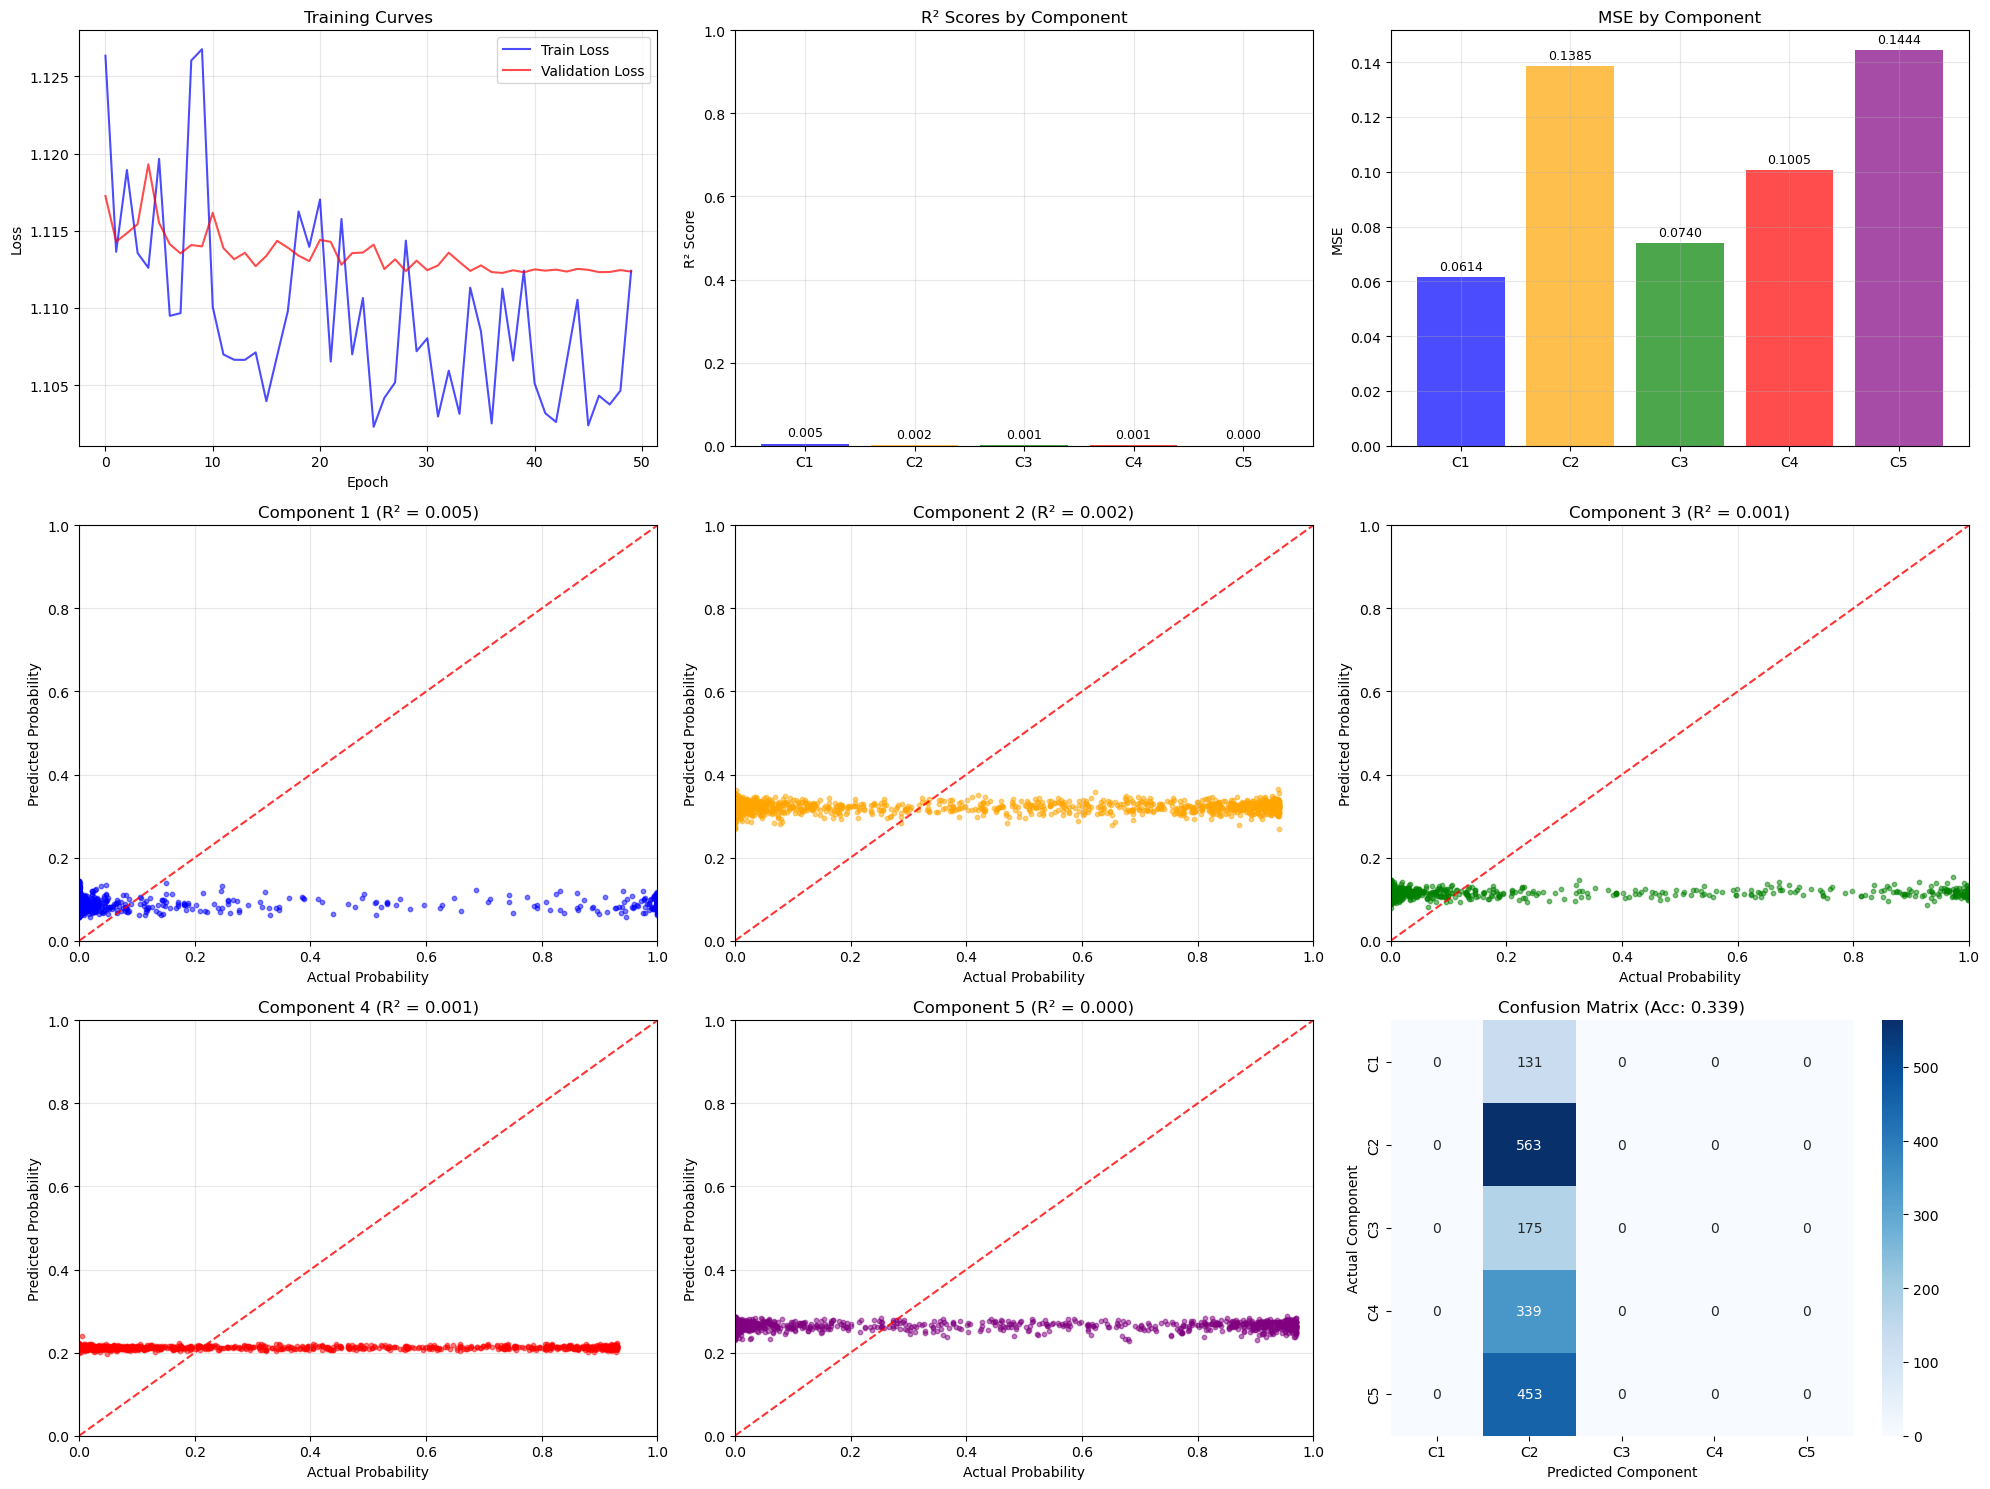

✅ Visualization saved to: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results/plots/optimized_cnn_results.png


In [ ]:
# Comprehensive Visualization
print("📊 Creating comprehensive visualizations...")

# Create subplots
fig = plt.figure(figsize=(20, 15))

# 1. Training curves
ax1 = plt.subplot(3, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. R² scores by component
ax2 = plt.subplot(3, 3, 2)
r2_scores = [metrics[f'Component_{i+1}']['R2'] for i in range(5)]
colors = ['blue', 'orange', 'green', 'red', 'purple']
bars = plt.bar(['C1', 'C2', 'C3', 'C4', 'C5'], r2_scores, color=colors, alpha=0.7)
plt.ylabel('R² Score')
plt.title('R² Scores by Component')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# 3. MSE by component
ax3 = plt.subplot(3, 3, 3)
mse_scores = [metrics[f'Component_{i+1}']['MSE'] for i in range(5)]
bars = plt.bar(['C1', 'C2', 'C3', 'C4', 'C5'], mse_scores, color=colors, alpha=0.7)
plt.ylabel('MSE')
plt.title('MSE by Component')
plt.grid(True, alpha=0.3)
# Add value labels on bars
for bar, score in zip(bars, mse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mse_scores)*0.01, 
             f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# 4-8. Scatter plots for each component
positions = [(3, 3, 4), (3, 3, 5), (3, 3, 6), (3, 3, 7), (3, 3, 8)]
for i in range(5):
    ax = plt.subplot(*positions[i])
    plt.scatter(targets_test[:, i], predictions[:, i], alpha=0.5, s=10, color=colors[i])
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.8)
    plt.xlabel('Actual Probability')
    plt.ylabel('Predicted Probability')
    plt.title(f'Component {i+1} (R² = {metrics[f"Component_{i+1}"]["R2"]:.3f})')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

# 9. Confusion matrix for dominant component prediction
ax9 = plt.subplot(3, 3, 9)
cm = confusion_matrix(actual_components, predicted_components)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'C{i+1}' for i in range(5)], 
            yticklabels=[f'C{i+1}' for i in range(5)])
plt.xlabel('Predicted Component')
plt.ylabel('Actual Component')
plt.title(f'Confusion Matrix (Acc: {classification_accuracy:.3f})')

plt.tight_layout()
plt.savefig(f'{ROOT}/results/plots/optimized_cnn_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved to: {ROOT}/results/plots/optimized_cnn_results.png")


In [ ]:
# Model Performance Summary
print("📋 Optimized CNN Performance Summary")
print("=" * 50)

print(f"\n🏗️ Architecture:")
print(f"   Model: PromoterCNN")
print(f"   Depth: {config['depth']} conv blocks")
print(f"   Base channels: {config['base_channels']}")
print(f"   Dropout: {config['dropout']}")
print(f"   Parameters: {total_params:,}")

print(f"\n🎓 Training:")
print(f"   Optimizer: {config['optimizer']}")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Batch size: {config['batch_size']}")
print(f"   Loss function: {config.get('loss_function', 'kldiv')}")
print(f"   Epochs trained: {len(train_losses)}")
print(f"   Best validation loss: {best_val_loss:.6f}")
print(f"   Training time: {total_time:.1f}s ({total_time/60:.1f} min)")

print(f"\n📊 Performance:")
print(f"   Overall R²: {overall_r2:.4f}")
print(f"   Overall MSE: {overall_mse:.6f}")
print(f"   Overall Correlation: {overall_corr:.4f}")
print(f"   Classification Accuracy: {classification_accuracy:.4f} ({classification_accuracy*100:.1f}%)")

print(f"\n🎯 Component Performance:")
for i, name in enumerate(component_names):
    r2 = metrics[name]['R2']
    mse = metrics[name]['MSE']
    print(f"   {name}: R²={r2:.4f}, MSE={mse:.6f}")

print(f"\n💾 Saved Files:")
print(f"   Model weights: {ROOT}/results/model_weights/best_promoter_cnn_optimized.pth")
print(f"   Visualization: {ROOT}/results/plots/optimized_cnn_results.png")

# Save metrics to JSON
results_summary = {
    'model_config': config,
    'training_results': {
        'epochs_trained': len(train_losses),
        'best_val_loss': best_val_loss,
        'final_train_loss': train_losses[-1],
        'training_time_seconds': total_time
    },
    'performance_metrics': metrics,
    'classification_accuracy': classification_accuracy
}

with open(f'{ROOT}/results/analysis/optimized_cnn_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"   Results summary: {ROOT}/results/analysis/optimized_cnn_results.json")
print(f"\n✅ Optimized CNN training and evaluation completed successfully!")


📋 Optimized CNN Performance Summary

🏗️ Architecture:
   Model: PromoterCNN
   Depth: 4 conv blocks
   Base channels: 64
   Dropout: 0.3
   Parameters: 28,037

🎓 Training:
   Optimizer: adamw
   Learning rate: 0.0005
   Batch size: 64
   Loss function: kldiv
   Epochs trained: 50
   Best validation loss: 1.112269
   Training time: 88.6s (1.5 min)

📊 Performance:
   Overall R²: 0.0713
   Overall MSE: 0.103774
   Overall Correlation: 0.2671
   Classification Accuracy: 0.3390 (33.9%)

🎯 Component Performance:
   Component_1: R²=0.0053, MSE=0.061446
   Component_2: R²=0.0021, MSE=0.138541
   Component_3: R²=0.0010, MSE=0.073988
   Component_4: R²=0.0009, MSE=0.100521
   Component_5: R²=0.0003, MSE=0.144376

💾 Saved Files:
   Model weights: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results/model_weights/best_promoter_cnn_optimized.pth
   Visualization: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Researc

In [ ]:
# Example Predictions
print("🧬 Example Predictions on Test Sequences")
print("=" * 50)

# Get a few test examples
model.eval()
with torch.no_grad():
    for i in range(min(5, len(test_dataset))):
        sample = test_dataset[i]
        sequence = sample['sequence'].unsqueeze(0).to(device_obj)
        actual_target = sample['target'].numpy()
        
        # Get prediction
        logits = model(sequence)
        predicted_probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        
        predicted_component = np.argmax(predicted_probs) + 1
        actual_component = np.argmax(actual_target) + 1
        confidence = np.max(predicted_probs)
        
        print(f"\n🧪 Test Example {i+1}:")
        print(f"   Predicted Component: {predicted_component} (confidence: {confidence:.3f})")
        print(f"   Actual Component: {actual_component}")
        print(f"   Match: {'✅ Yes' if predicted_component == actual_component else '❌ No'}")
        
        print(f"   Predicted probabilities:")
        for j, prob in enumerate(predicted_probs):
            print(f"     Component {j+1}: {prob:.4f}")
        
        print(f"   Actual probabilities:")
        for j, prob in enumerate(actual_target):
            print(f"     Component {j+1}: {prob:.4f}")

print(f"\n🎉 Optimized CNN analysis complete!")


🧬 Example Predictions on Test Sequences

🧪 Test Example 1:
   Predicted Component: 2 (confidence: 0.324)
   Actual Component: 4
   Match: ❌ No
   Predicted probabilities:
     Component 1: 0.0808
     Component 2: 0.3240
     Component 3: 0.1147
     Component 4: 0.2112
     Component 5: 0.2693
   Actual probabilities:
     Component 1: 0.0144
     Component 2: 0.1389
     Component 3: 0.0000
     Component 4: 0.8467
     Component 5: 0.0000

🧪 Test Example 2:
   Predicted Component: 2 (confidence: 0.306)
   Actual Component: 4
   Match: ❌ No
   Predicted probabilities:
     Component 1: 0.0918
     Component 2: 0.3062
     Component 3: 0.1271
     Component 4: 0.2165
     Component 5: 0.2584
   Actual probabilities:
     Component 1: 0.0144
     Component 2: 0.1391
     Component 3: 0.0000
     Component 4: 0.8465
     Component 5: 0.0000

🧪 Test Example 3:
   Predicted Component: 2 (confidence: 0.297)
   Actual Component: 5
   Match: ❌ No
   Predicted probabilities:
     Component 1: